# Direct Forecasting with skforecast
Conda environment: `time-series`   
20 May 2024  

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect

In [3]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [4]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("H")
    .agg({"demand": "sum"})
)

df

,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"
...,...
2015-02-28 19:00:00,"9,596.7771"
2015-02-28 20:00:00,"8,883.2303"
2015-02-28 21:00:00,"8,320.2605"


In [5]:
# Split into train and test. We leave 2015 in the test set
end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

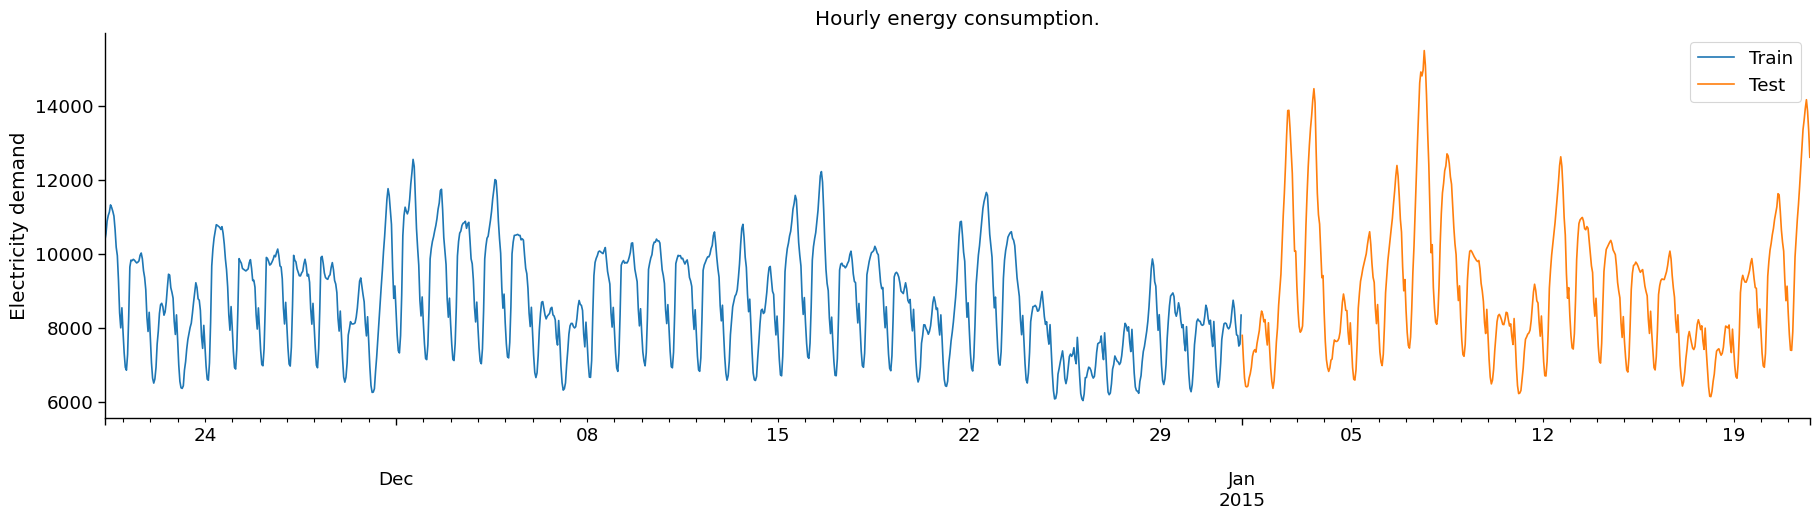

In [6]:
fig, ax = plt.subplots()

X_train.tail(1000).plot(ax=ax)
X_test.head(500).plot(ax=ax)

ax.set_title('Hourly energy consumption.')
ax.legend(["Train", "Test"])
ax.set_xlabel("")
ax.set_ylabel("Electricity demand")

plt.show()

## 2) Direct Forecasting

In [8]:
HORIZON = 24

# Lasso regression model
lasso = Lasso(random_state=9, max_iter=1000)

# Forecaster
forecaster = ForecasterAutoregDirect(
    regressor=lasso,            # the machine learning model
    lags=24,                    # the lag features to create
    steps=HORIZON,              # the horizon
    forecaster_id="direct"
)

# fit the forecaster
forecaster.fit(y=X_train["demand"])

# print
forecaster

/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e+09, tolerance: 3.156e+07
  model = cd_fast.enet_coordinate_descent(
/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.398e+09, tolerance: 3.156e+07
  model = cd_fast.enet_coordinate_descent(
/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

ForecasterAutoregDirect 
Regressor: Lasso(random_state=9) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Window size: 24 
Maximum steps predicted: 24 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2002-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 9, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-20 17:02:12 
Last fit date: 2024-05-20 17:03:09 
Skforecast version: 0.11.0 
Python version: 3.11.6 
Forecaster id: direct 

### 2.1) Predict

In [9]:
# Forecast the next 24 hours (starting on 
# last fit date:2024-02-15 17:37:16 + 1 hr
predictions = forecaster.predict(steps=24)

pd.DataFrame(predictions).reset_index()

,index,pred
0,2015-01-01 00:00:00,"8,379.2433"
1,2015-01-01 01:00:00,"7,980.1753"
2,2015-01-01 02:00:00,"7,628.6746"
3,2015-01-01 03:00:00,"7,485.7710"
4,2015-01-01 04:00:00,"7,678.9505"
5,2015-01-01 05:00:00,"8,092.1976"
6,2015-01-01 06:00:00,"8,684.0785"
7,2015-01-01 07:00:00,"8,853.2218"
8,2015-01-01 08:00:00,"8,995.7315"
9,2015-01-01 09:00:00,"8,993.9611"


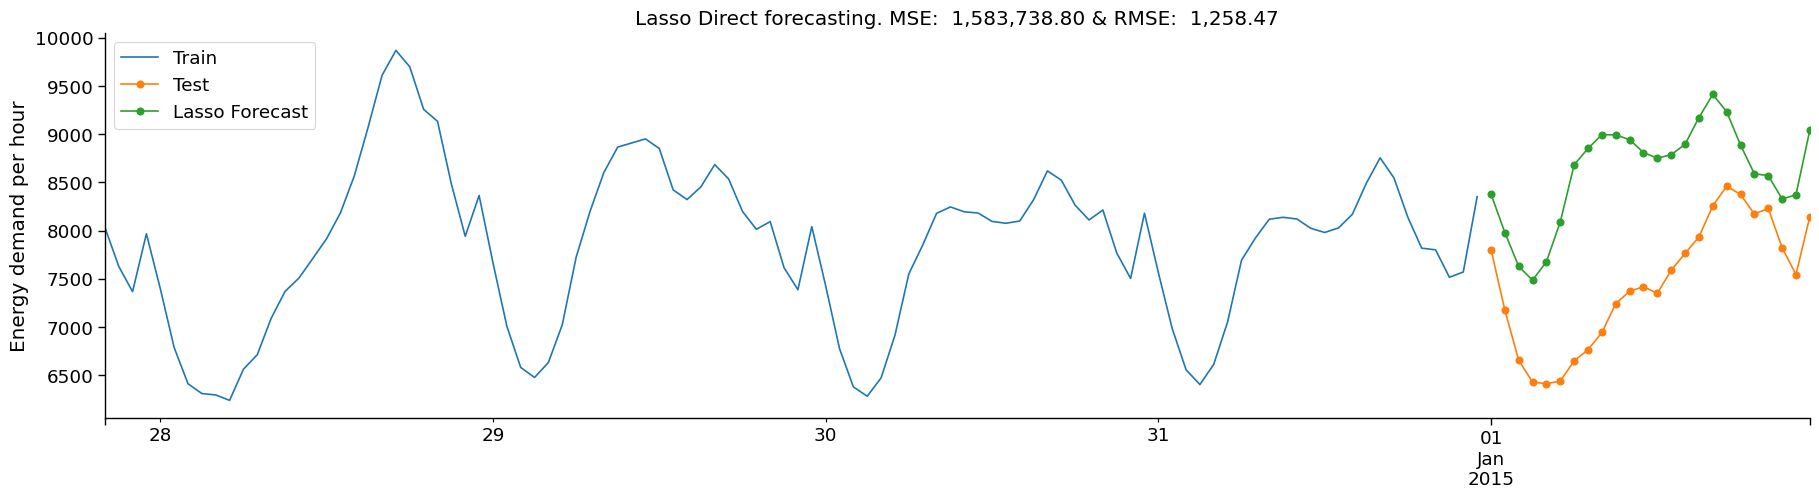

In [13]:
# MSE
error_mse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index] , 
                y_pred = predictions,
                squared=True,
            )
# RMSE 
error_rmse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index], 
                y_pred = predictions,
                squared=False,
            )

fig, ax = plt.subplots()

X_train.tail(100).plot(ax=ax)
X_test.head(24).plot(ax=ax, marker="o")
predictions.plot(ax=ax, marker="o")

ax.legend(["Train", "Test", "Lasso Forecast"])
plt.title(f"Lasso Direct forecasting. MSE: {error_mse: ,.2f} & RMSE: {error_rmse: ,.2f}")
plt.ylabel("Energy demand per hour")
plt.xlabel("")

plt.show()

### 2.2) Predict any time point in the future

In [15]:
# Say we want to predict energy demand for 1st of February
forecast_start = '2015-02-01 00:00:00'

# we need the energy demand up to 144 hs before that point
past_data_available = X_test[:'2015-01-31 23:59:59'].tail(forecaster.window_size)

predictions = forecaster.predict(
    steps=HORIZON, 
    last_window=past_data_available["demand"], # we pass the data up to Feb 2015
)

pd.DataFrame(predictions).reset_index()

,index,pred
0,2015-02-01 00:00:00,"8,337.0802"
1,2015-02-01 01:00:00,"7,865.8172"
2,2015-02-01 02:00:00,"7,486.6511"
3,2015-02-01 03:00:00,"7,369.9277"
4,2015-02-01 04:00:00,"7,503.0076"
5,2015-02-01 05:00:00,"7,874.4025"
6,2015-02-01 06:00:00,"8,371.0756"
7,2015-02-01 07:00:00,"8,660.7243"
8,2015-02-01 08:00:00,"8,985.8266"
9,2015-02-01 09:00:00,"9,084.4251"


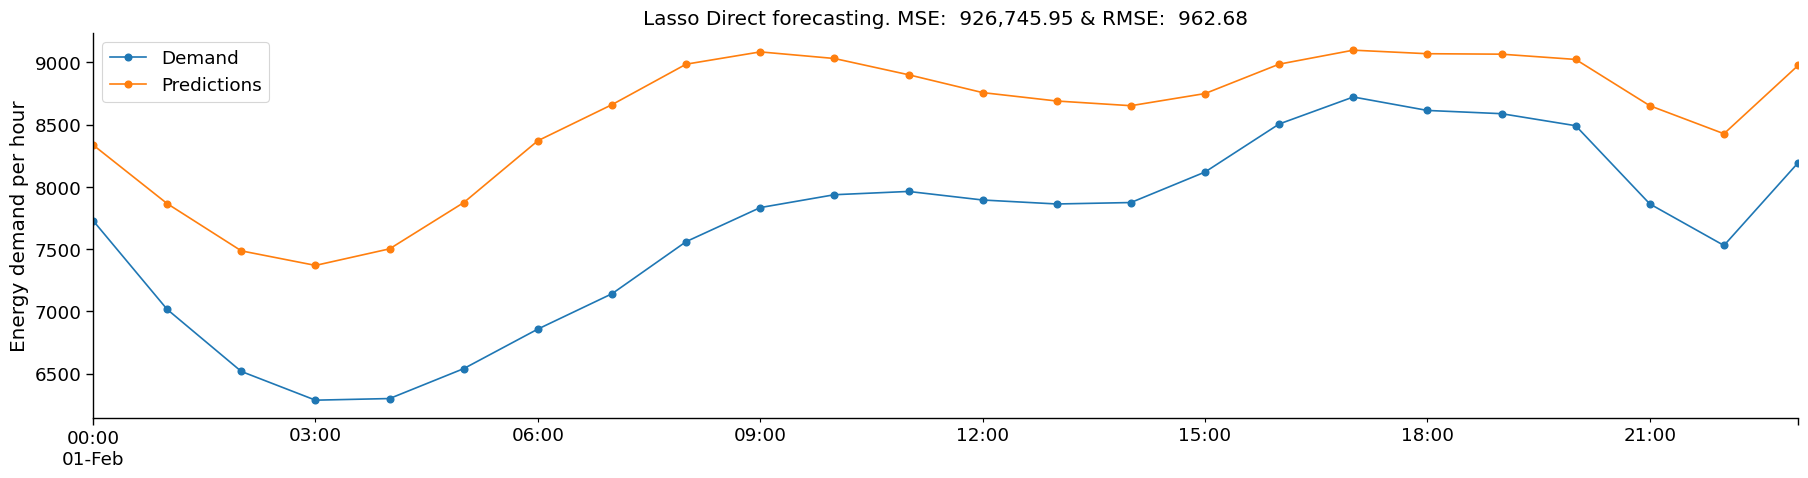

In [23]:
# MSE
error_mse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index] , 
                y_pred = predictions,
                squared=True,
            )
# RMSE 
error_rmse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index], 
                y_pred = predictions,
                squared=False,
            )

fig, ax = plt.subplots()

X_test['2015-01-31 23:59:59':].head(24).plot(ax=ax, marker="o")
predictions.plot(ax=ax, marker="o")

ax.legend(["Demand", "Predictions"])
plt.title(f"Lasso Direct forecasting. MSE: {error_mse: ,.2f} & RMSE: {error_rmse: ,.2f}")
plt.ylabel("Energy demand per hour")
plt.xlabel("")

plt.show()

## 3) Feature importance

In [24]:
forecaster.regressors_

{1: Lasso(random_state=9),
 2: Lasso(random_state=9),
 3: Lasso(random_state=9),
 4: Lasso(random_state=9),
 5: Lasso(random_state=9),
 6: Lasso(random_state=9),
 7: Lasso(random_state=9),
 8: Lasso(random_state=9),
 9: Lasso(random_state=9),
 10: Lasso(random_state=9),
 11: Lasso(random_state=9),
 12: Lasso(random_state=9),
 13: Lasso(random_state=9),
 14: Lasso(random_state=9),
 15: Lasso(random_state=9),
 16: Lasso(random_state=9),
 17: Lasso(random_state=9),
 18: Lasso(random_state=9),
 19: Lasso(random_state=9),
 20: Lasso(random_state=9),
 21: Lasso(random_state=9),
 22: Lasso(random_state=9),
 23: Lasso(random_state=9),
 24: Lasso(random_state=9)}

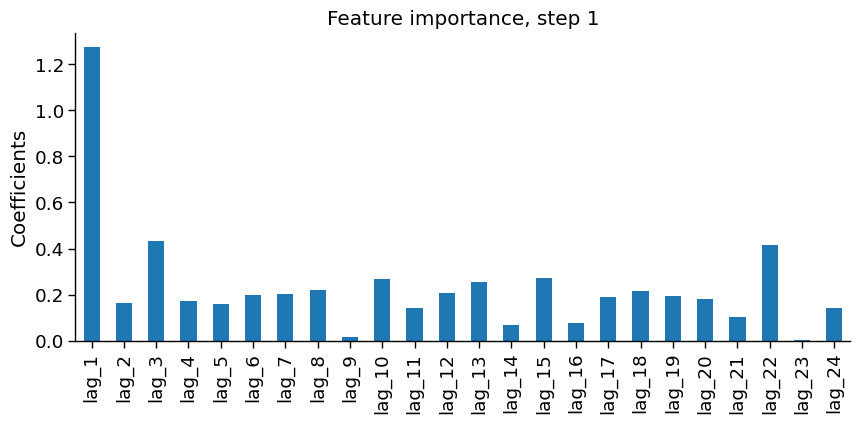

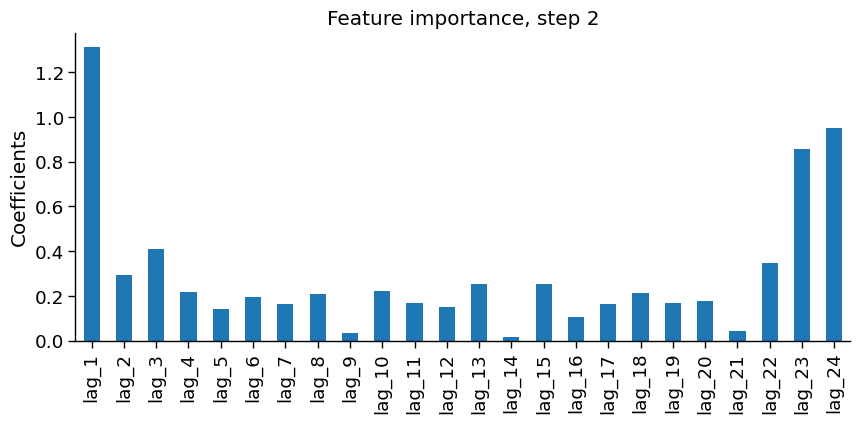

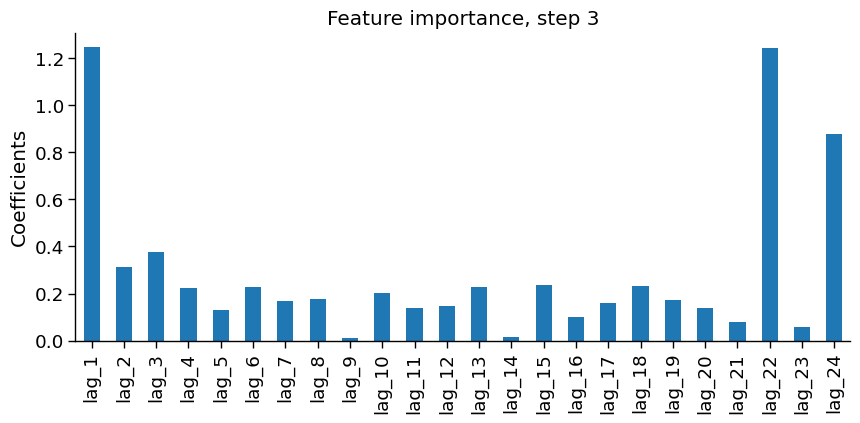

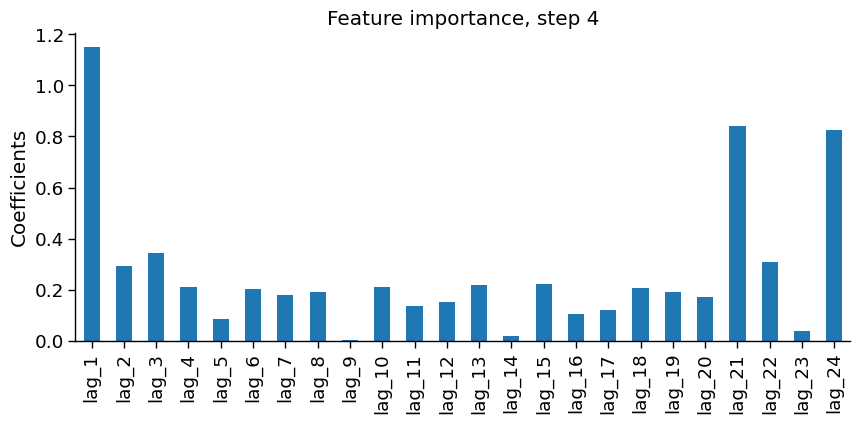

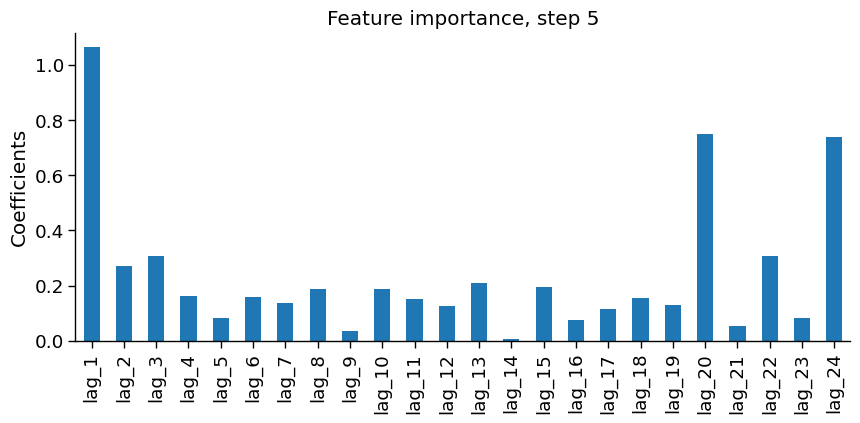

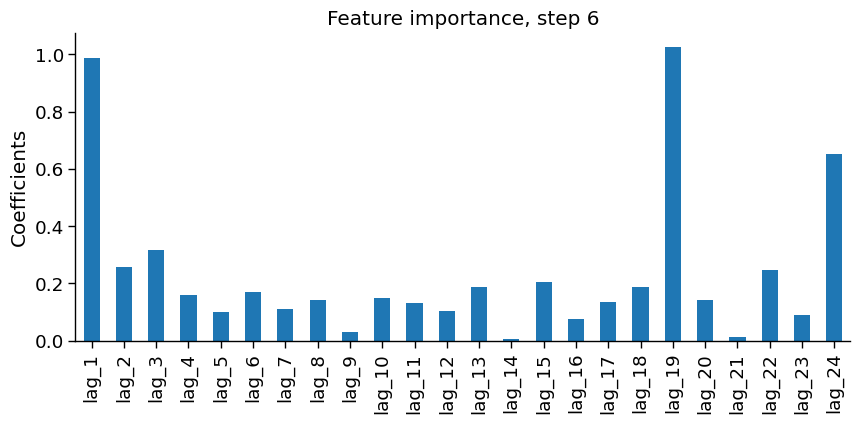

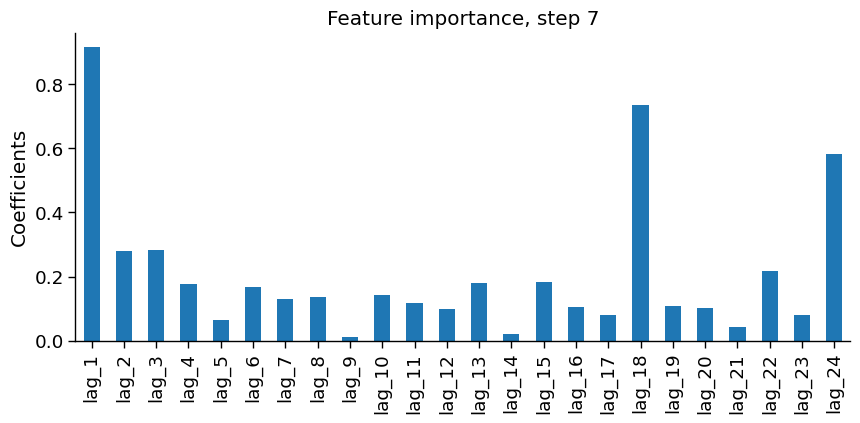

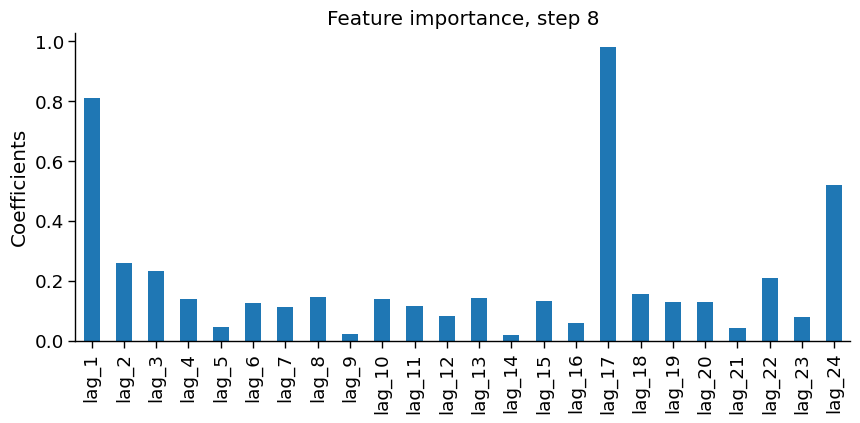

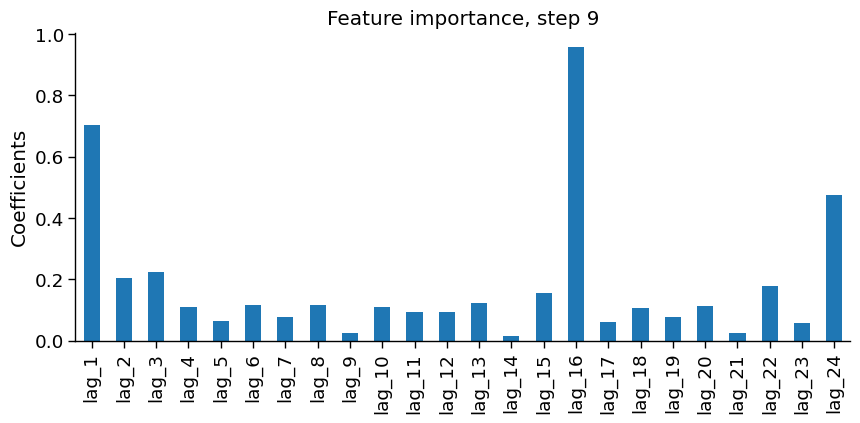

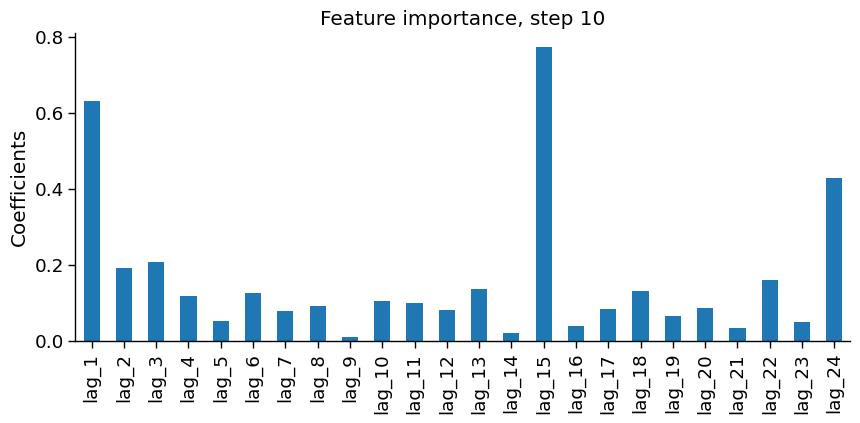

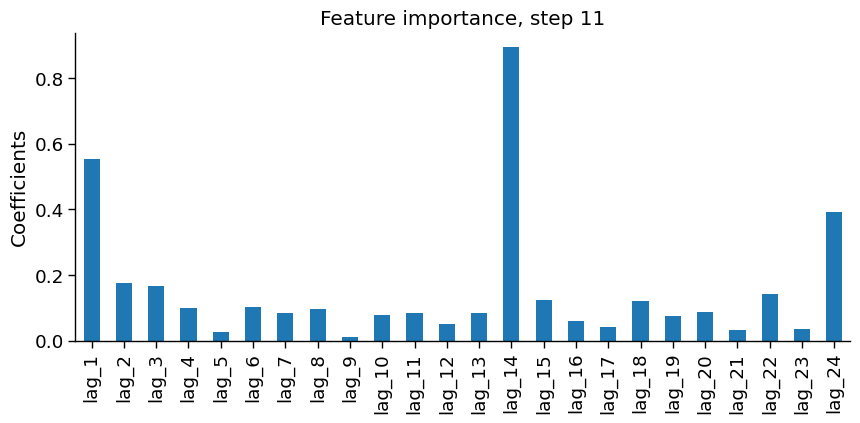

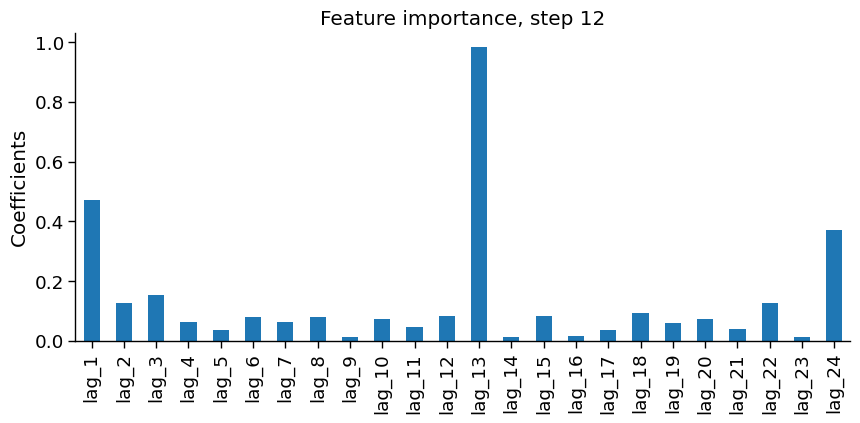

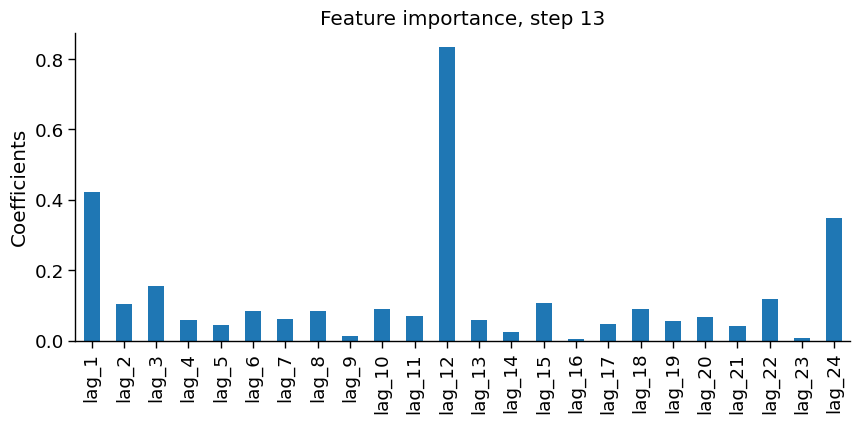

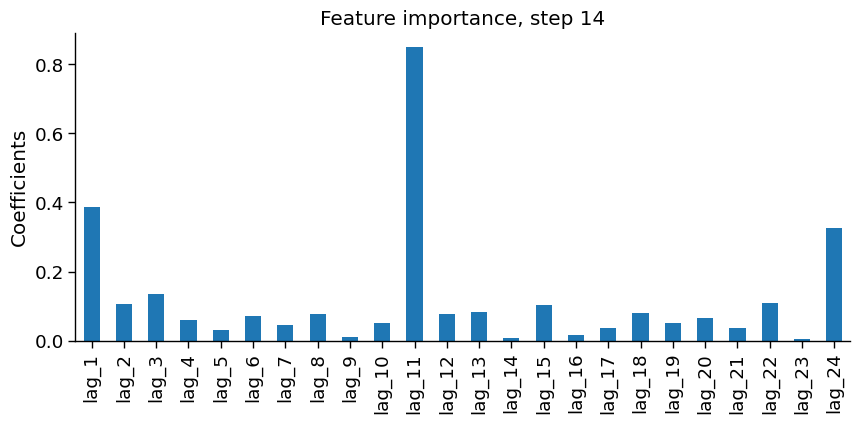

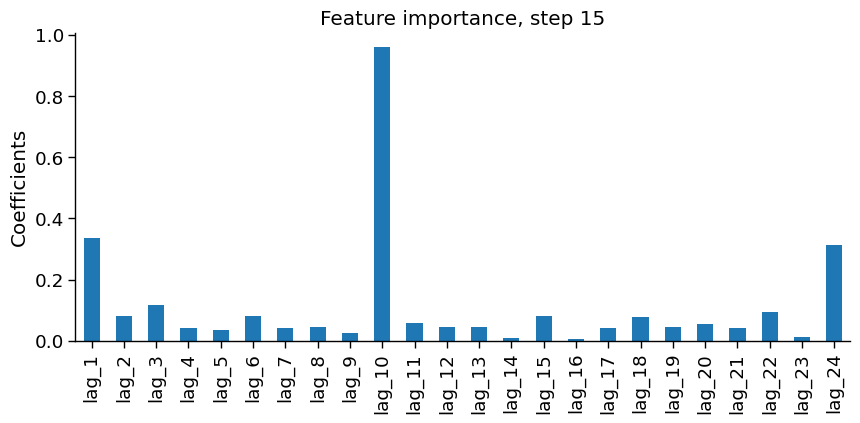

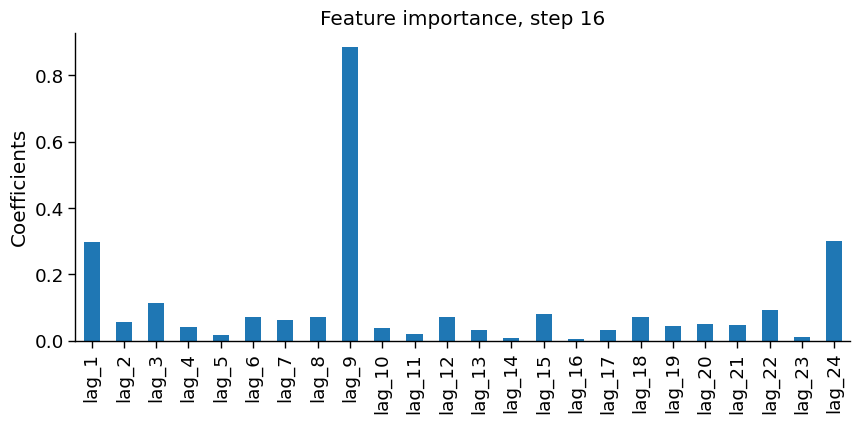

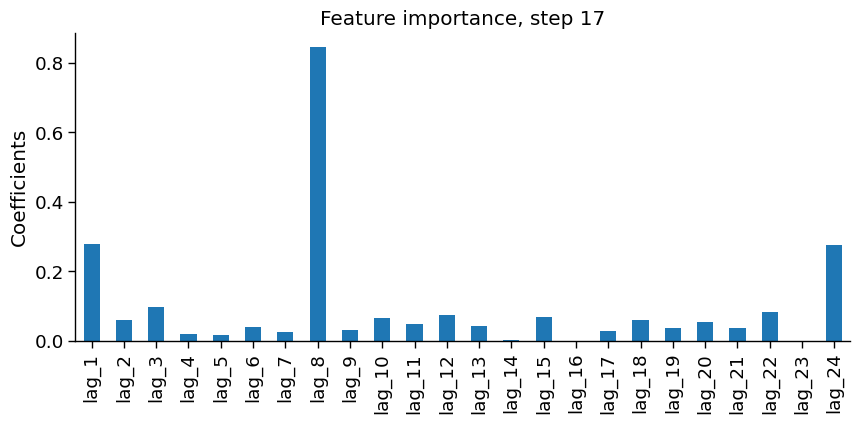

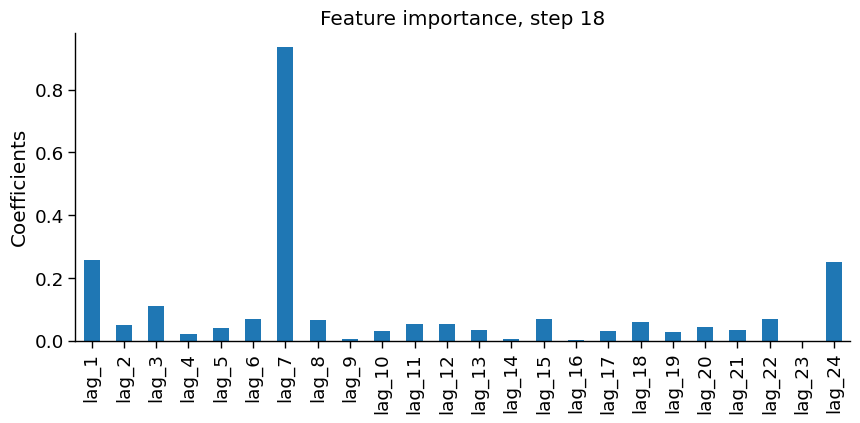

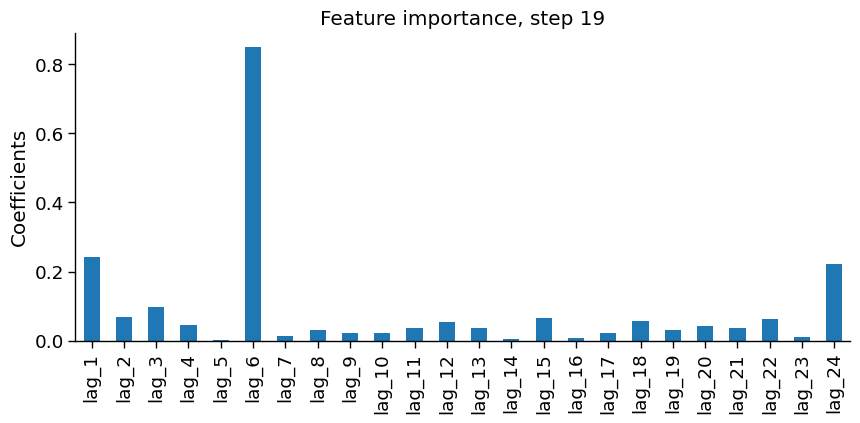

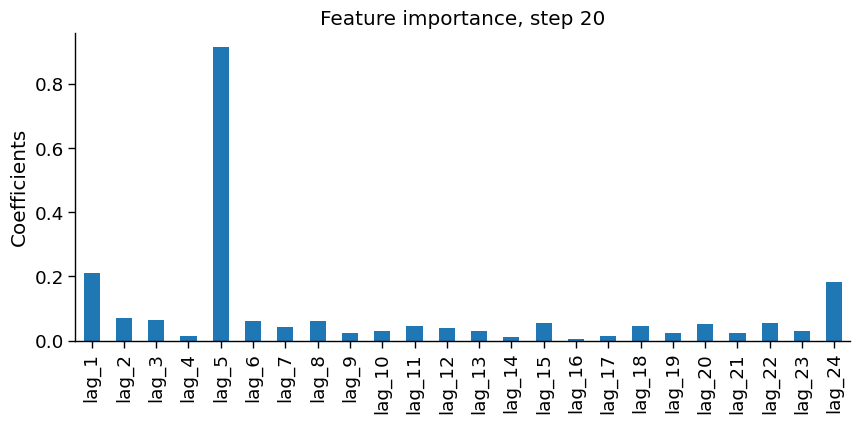

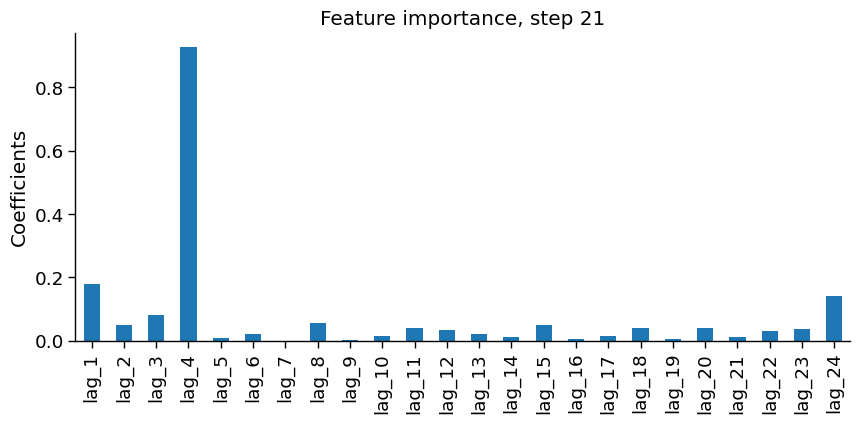

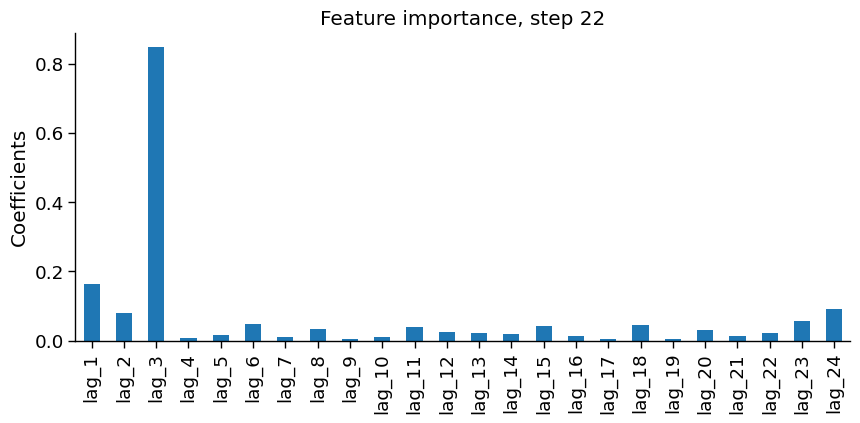

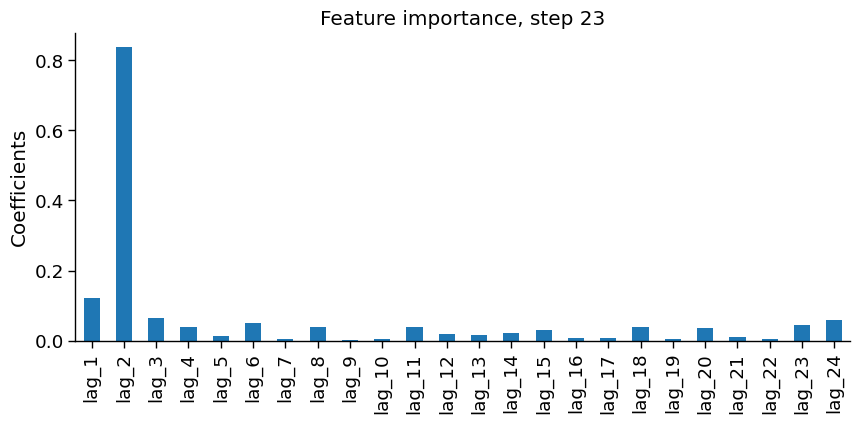

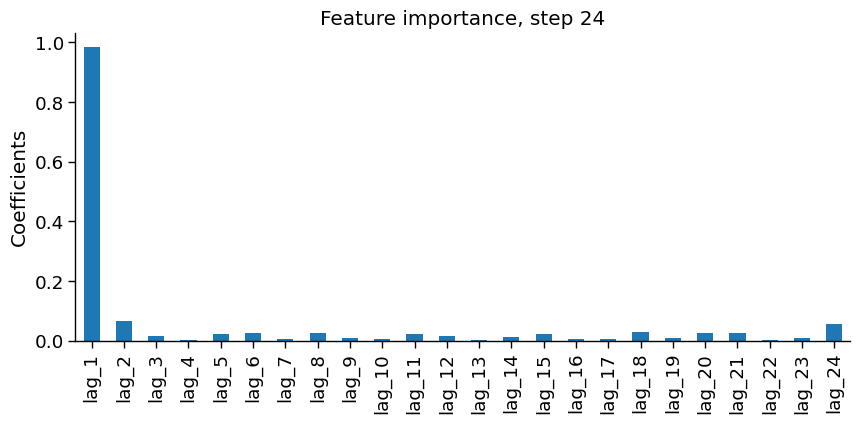

In [30]:
for h in range(1,25):
    lasso_ = forecaster.regressors_[h]
    (pd.Series(
        lasso_.coef_,
        index=lasso_.feature_names_in_)
        .abs()
        .plot(kind="bar", figsize=(10,4))
    )
    plt.title(f"Feature importance, step {h}")
    plt.ylabel("Coefficients")
    plt.show()